In [1]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW as TorchAdamW
import pandas as pd
from textwrap import wrap
import csv
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
RANDOM_SEED = 42
MAX_LEN = 200
BATCH_SIZE = 10
DATASET_PATH = '/content/BERT_sentiment_IMDB_Dataset.csv'
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
df = pd.read_csv(DATASET_PATH)
df = df[0:10000]

In [4]:
print(df.head())
print(df.shape)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
(10000, 2)


In [5]:
df['label'] = (df['sentiment']=='positive').astype(int)
df.drop('sentiment', axis=1, inplace=True)
df.head()

,review,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


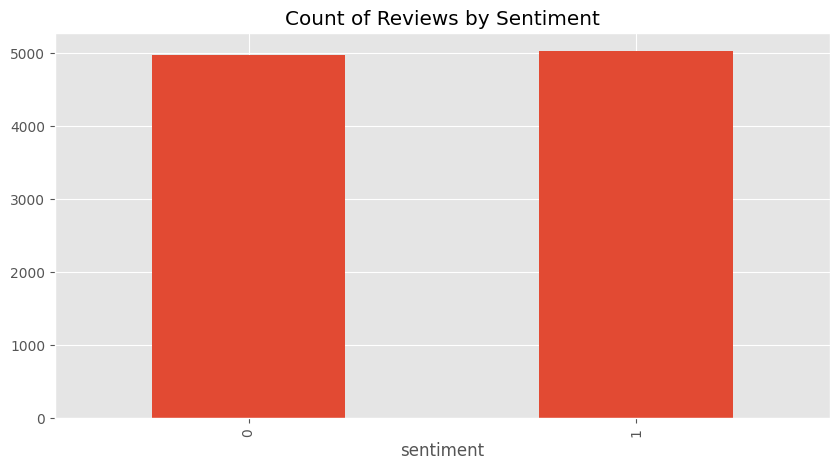

In [6]:

ax = df['label'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('sentiment')
plt.show()

In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# Ejemplo tokenización
sample_txt = 'I really loved that movie!'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)


Frase:  I really loved that movie!
Tokens:  ['I', 'really', 'loved', 'that', 'movie', '!']
Tokens numéricos:  [146, 1541, 3097, 1115, 2523, 106]


In [11]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 10,
    truncation = True,
    add_special_token = True,
    return_token_types_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'add_special_token': True, 'return_token_types_ids': False} not recognized.


In [13]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])


['[CLS]', 'I', 'really', 'loved', 'that', 'movie', '!', '[SEP]', '[PAD]', '[PAD]']
tensor([ 101,  146, 1541, 3097, 1115, 2523,  106,  102,    0,    0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [18]:
# CREACIÓN DATASET

class BertDataset(Dataset):

  def __init__(self,reviews,labels,tokenizer,max_len):
    self.reviews = reviews
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus( #entrada modelo bert
        review,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )


    return {
          'review': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }


In [19]:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = BertDataset(
      reviews = df.review.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )
  dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)
  return dataloader
  # return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 2)

In [20]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED) #tamaño del set de prueba es el 20%

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
# Modelo

class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False) #modelo preentrenado
    self.bert_drop = nn.Dropout(0.4) #apagar el 40% de las neuronas aleatoriamente durante el entrenamiento para disminuir el Overfitting
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes) #crear la capa de neuronas con 768 de entrada y 2 neuronas de salida, porque el modelo bert tiene 768 neuronas de salida

  def forward(self, input_ids, attention_mask):#orden en que pasan los datos, conxx entre capas
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.bert_drop(cls_output)
    output = self.linear(drop_output)
    return output



In [24]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

In [25]:
EPOCHS = 5
optimizer = TorchAdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [26]:
# Funciones para entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #para evitar que el gradiente crezca demasiado
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [27]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/tokeniza

Entrenamiento: Loss: 0.38815235177986324, accuracy: 0.824375
Validación: Loss: 0.3425156918936409, accuracy: 0.892

Epoch 2 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.21775526129626088, accuracy: 0.93575
Validación: Loss: 0.4978718558273977, accuracy: 0.892

Epoch 3 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.11719092259318131, accuracy: 0.9712500000000001
Validación: Loss: 0.5506215545180021, accuracy: 0.892

Epoch 4 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.04917816419516385, accuracy: 0.989375
Validación: Loss: 0.6294299328589114, accuracy: 0.8995

Epoch 5 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.021858390098605015, accuracy: 0.99525
Validación: Loss: 0.6881338893236171, accuracy: 0.898



In [28]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )

  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print("\n".join(wrap(review_text)))
  if prediction:
    print(' * * * * * ')
  else:
    print(' * ')

In [30]:
review_txt1 = "It is 300 years later and that roadmap seems to have taken some shortcuts and detours, but, as in all re-imaginings, new pathways are important to keep the audience from nodding off or hitting the fast-forward button."
classifySentiment(review_txt1)
review_txt2 = "As long as there’s another excuse to slap Garfield on another t-shirt, let’s keep the train rolling with a new generation of fans. When brand perpetuation is as soulless and milquetoast as this, it seems unlikely that it will create any new fans at all."
classifySentiment(review_txt2)
review_txt3 = "The Garfield Movie may be as disposable as one of those numbered paperbacks that ex-kids of a certain age may fondly recall from their Scholastic book orders, but it approximates their sense of fun, too."
classifySentiment(review_txt3)
review_txt4 = "In trying to reinvent the lazy feline for modern kids, the filmmakers have lost track of the comedic tone that has helped these simple, gag-driven stories endure for decades."
classifySentiment(review_txt4)
review_txt5 = "I can’t think of the last time I saw a movie as bland generic as “The Garfield Movie,” which crunches Jim Davis’ misanthropic comic-strip cat into one more piece of pre-digested intellectual property. "
classifySentiment(review_txt5)

It is 300 years later and that roadmap seems to have taken some
shortcuts and detours, but, as in all re-imaginings, new pathways are
important to keep the audience from nodding off or hitting the fast-
forward button.
 * * * * * 
As long as there’s another excuse to slap Garfield on another t-shirt,
let’s keep the train rolling with a new generation of fans. When brand
perpetuation is as soulless and milquetoast as this, it seems unlikely
that it will create any new fans at all.
 * 
The Garfield Movie may be as disposable as one of those numbered
paperbacks that ex-kids of a certain age may fondly recall from their
Scholastic book orders, but it approximates their sense of fun, too.
 * * * * * 
In trying to reinvent the lazy feline for modern kids, the filmmakers
have lost track of the comedic tone that has helped these simple, gag-
driven stories endure for decades.
 * 
I can’t think of the last time I saw a movie as bland generic as “The
Garfield Movie,” which crunches Jim Davis’ mi

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
